<a href="https://colab.research.google.com/github/HaozheTian/ColabProjects/blob/main/custom_dataset_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Tutorial from Scratch 
This tutorial demonstrates deep learning using Google CoLaborotory (Colab). Colab is an online python editor that allows editing, execution, and even better, free GPU access.

Different from existing tutorials, this tutorial emphasizes actual problems an engineer/researcher might encounter, such as:
* How to configure a runtime
* How to use custom datasets

Whereas standard deep learning workflow, which has been covered by many tutorials, will not be covered.

## A. Runtime Configuration
While Colab has many built-in packages such as `numpy`, `scipy`, `pandas`, and `pytorch`, you might come across packages that are not pre-installed. To use these packages, installation must be performed at the beginning of each runtime.

When running virtual environments on our own PC, `pip install` is usually used. Things work similarly in Colab, except a `!` needs to be added to indicate console command. Let us first see how `pip` works by looking at its help document. (I am sure you are familiar with command line operations, but let's try this anyway to show that thins works similar on Colab.)

In [3]:
!pip -h | head -n 10


Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  list                        List installed packages.


The `-h` pulls out the help doc. The second part `| head -n 10` limits command line output to the first 5 lines (for asthetics).

Now let us install a package. We will use `tqdm`, a progress bar tool, as an example.

In [4]:
!pip -q install tqdm

import tqdm
print(f'Version {tqdm.__version__} installed')

Version 4.65.0 installed


Here `-q` is used to run installation in "quiet" mode, therefore reducing command line outputs. It is only kept here for asthetic purpose.

## B. Access Data in Colab
For demonstration, a .zip file containing 100 of the 202599 images from the original [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html#:~:text=CelebFaces%20Attributes%20Dataset%20(CelebA)%20is,quantities%2C%20and%20rich%20annotations%2C%20including) dataset will be used. To download the demo dataset, go [**here**](https://github.com/HaozheTian/ColabProjects/raw/main/img_align_celeba.zip).

To use the dataset, the first thing is to upload it to your [Google Drive](https://drive.google.com/drive/my-drive). After doing so, let's see how to access files stored in Google Drive using Colab. Run the following code.

**Caution:** Upload the .zip file instead of unzip images, as uploading unziped folder to Google Drive takes forever.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/

Mounted at /content/drive
ECG-ML	img_align_celeba.zip  VAE


Now we unzip the uploaded test data. Similar to before, `-q` i.e. quiet mode is used. Note the exact directory where the target .zip file is stored various.

In [6]:
!unzip -q /content/drive/MyDrive/img_align_celeba.zip

By using the default working directory, the unziped data file should appear in "/content/". Here is what it looks like:

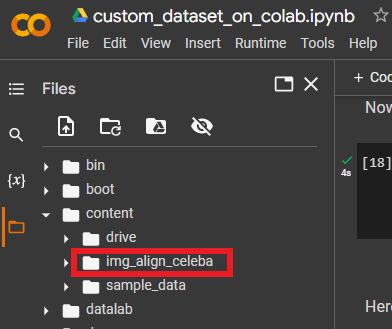

Now the data file can be accessed in Colab as if it is stored on your own device. Note that if the runtime is disconnected, you have to start over from the unzipping step.

## C. Use Custom Data
Before progressing to custom dataset, let us first review how we used datasets contained in PyTorch. Take the MNIST dataset as an example:

In [7]:
import torchvision
import torch
from torchvision import datasets, transforms

# Define transforms
# Here only a simple tensor conversion and batch normalization is performed
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,],std=[0.5,], )])

# here root specifies where to store the data
data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

# Train data loader
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 4,
                                                shuffle = True)
for images, label in data_loader_train:
  print(images.shape)
  break

torch.Size([4, 1, 28, 28])


The data loader is an iterator that returns a batch of 4 grayscale images (1 channel), each with size (28$\times$28).

Now let us move on to the celebrity face dataset, which we just uploaded. We first load the index file:

In [9]:
import pandas as pd

df_celeb = pd.read_csv('/content/img_align_celeba/list_attr_celeba.txt', delim_whitespace = True, skiprows=1)
print(f'Total number of images: {df_celeb.shape[0]}')
df_celeb.head()

Total number of images: 100


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


It can be seen that there are 100 images, each with various attributes.

To use these data the same way as a pytorch built-in dataset, we need to code a custom dataset class. By inhereting from `torch.utils.data.Dataset`, we only need to rewrite two functions: `self.__getitem__` and `self.__len__`.

In [24]:
from numpy import float32
import torch
from torch.utils.data import Dataset
from PIL import Image

class CelebFaceDataset(Dataset):
    def __init__(self, df_index, transforms):
        self.df_index = df_index
        self.transforms = transforms

    def __getitem__(self, idx):
        img_id = self.df_index.loc[idx].image_id
        img_uri = '/content/img_align_celeba/' + img_id
        img = Image.open(img_uri)

        label_list = []
        for column in self.df_index.columns:
            label_list.append(self.df_index.iloc[idx][column])
        label = torch.tensor(label_list[1:], dtype = torch.float32)
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return self.df_index.shape[0]

In [25]:
# Define transforms
# Here only a simple tensor conversion and batch normalization is performed
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,],std=[0.5,], )])

# here root specifies where to store the data
data_custom = CelebFaceDataset(df_celeb, transform)

# Train data loader
data_loader_train = torch.utils.data.DataLoader(data_custom,
                                                batch_size = 4,
                                                shuffle = True)

In [26]:
for images, label in data_loader_train:
    print(images.shape)
    break

torch.Size([4, 3, 218, 178])
